### Import Libraries

In [1]:
from src.diffusion.ddpm import DDPM
from src.diffusion.unet import UNet
from src.data.mnist import get_mnist_loader_and_transform
from src.data.cifar10 import get_cifar10_loader_and_transform
from torchvision.utils import save_image, make_grid
from src.diffusion.train import train
import matplotlib.pyplot as plt

import torch.backends
import torch.backends.mps
import os

### Configuration of model

In [2]:
T = 1000
dataset = "mnist" # can be "cifar10" or "mnist"

PATH_TO_READY_MODEL = None # input path for ready model

PATH_TO_SAVE_MODEL = "model.pth"
EPOCHS = 100 # for cifar10 it should be more than 1000, but for mnist 20-100 should be okay

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# For Mac OS
if torch.backends.mps.is_available():
    device = "mps"
    print("USE MPS")

USE MPS


### Load dataset

In [4]:
if dataset == "mnist":
    data = get_mnist_loader_and_transform()
elif dataset == "cifar10":
    data = get_cifar10_loader_and_transform()

### Setup Model

In [5]:
ddpm = DDPM(
    T = T,
    eps_model=UNet(
        in_channels=data.in_channels,
        out_channels=data.out_channels,
        T=T+1,
        steps=data.recommended_steps,
        attn_step_indexes=data.recommended_attn_step_indexes
    ),
    device=device
)

### Train or load ready model

In [6]:
if PATH_TO_READY_MODEL is not None:
    ddpm.load_state_dict(torch.load(PATH_TO_READY_MODEL, map_location=device))
else:
    _, val_losses = train(
        model=ddpm,
        optimizer=torch.optim.Adam(params=ddpm.parameters(), lr=2e-4),
        epochs=EPOCHS,
        device=device,
        train_dataloader=data.train_loader,
        val_dataloader=data.val_loader
    )

    path = PATH_TO_SAVE_MODEL if PATH_TO_SAVE_MODEL is not None else "model.pth"

    torch.save(ddpm.state_dict(), path)

    plt.plot(val_losses, label="Validation Loss")

    plt.legend()

### Show samples

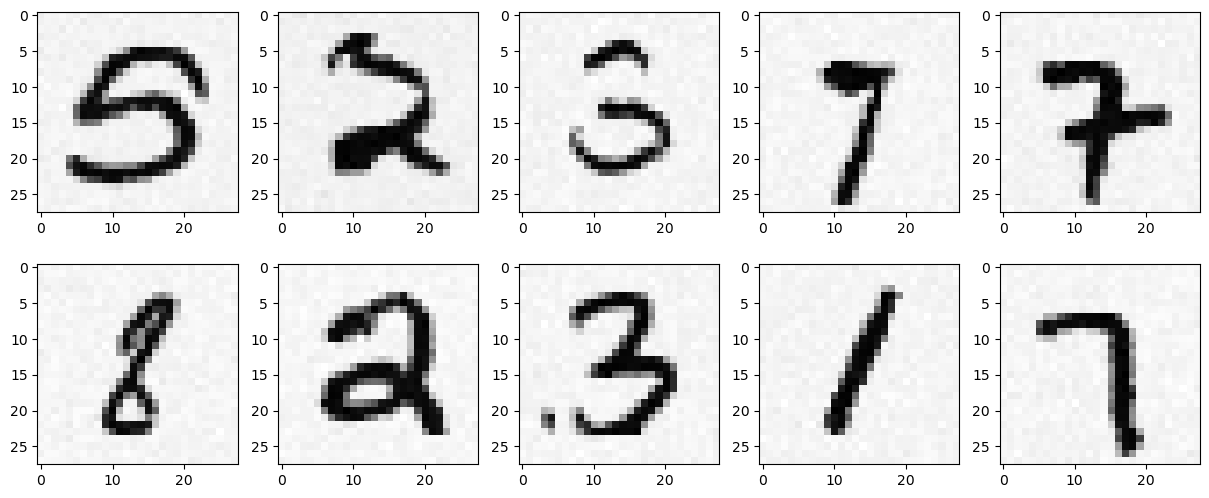

In [7]:
n_samples = 10
x_t = ddpm.sample(n_samples=n_samples, size=data.train_dataset[0][0].shape)

result = []
for i in range(x_t.shape[0]):
    result.append(data.transform_to_pil(x_t[i]))

grid = make_grid(x_t, nrow=10)
save_image(grid, f"sample.png")

cols = 5
rows = (n_samples // cols) + (0 if n_samples % cols == 0 else 1)
fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
for i in range(len(result)):
    row = i // cols
    axs[row, i % cols].imshow(result[i], cmap='gray')